In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Task 1: Natural Gas Storage Contracts Pricing

## Context
- **Role**: Quantitative researcher assisting a commodity trading desk.
- **Objective**: Help price natural gas storage contracts by extrapolating market data to provide more granularity, considering seasonal trends.
- **Challenge**: Existing market data is of insufficient quality for accurate pricing.

## Key Concepts
- **Commodity Storage Contracts**: Agreements between warehouse owners and supply chain participants to store commodities (e.g., natural gas) for a specified period.
  - **Key Terms**: Periodic storage fees, withdrawal/injection limits.
  - **Injection Date**: When the commodity is purchased and stored.
  - **Withdrawal Date**: When the commodity is withdrawn and sold.
- **Clients**: Entities in the supply chain (producers, refiners, traders, etc.) or firms aiming to profit from seasonal price differentials.

## Data Overview
- **Current Data Source**: Monthly snapshots of natural gas prices from a market data provider.
  - **Timeframe**: 31st October 2020 to 30th September 2024.
  - **Format**: CSV file with historical and future prices (up to 18 months).
- **Goal**: Use this data to estimate past prices and extrapolate future prices for up to one additional year.

## Tasks
1. **Download Data**: Access and download the monthly natural gas price data.
2. **Analyze Data**: Estimate the purchase price of natural gas at any past date and extrapolate for one year into the future.
3. **Visualize Data**: Identify patterns, such as seasonal trends, that affect natural gas prices.
4. **Develop Code**: Create a Python script that takes a date as input and returns a price estimate.

## Tools and Skills
- **Programming Language**: Python (commonly used in quantitative research at JPMorgan Chase).
- **Data Analysis**: Utilize data analysis and machine learning techniques.
- **Visualization**: Identify trends and factors influencing natural gas prices.

## Deliverables
- **Code**: Python script to estimate and extrapolate natural gas prices.
- **Visualizations**: Graphs or charts to illustrate seasonal trends and price patterns.
- **Output**: Price estimate for any given date, including future extrapolations.

## Next Steps
- Execute the analysis in a Jupyter Notebook (online or locally).
- Submit the completed code and visualizations for review.

Current working directory: /kaggle/working


<ipython-input-20-e58424863cdf>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Dates'])


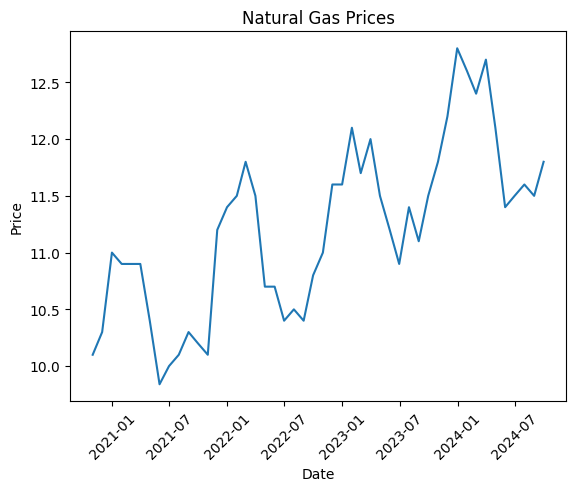

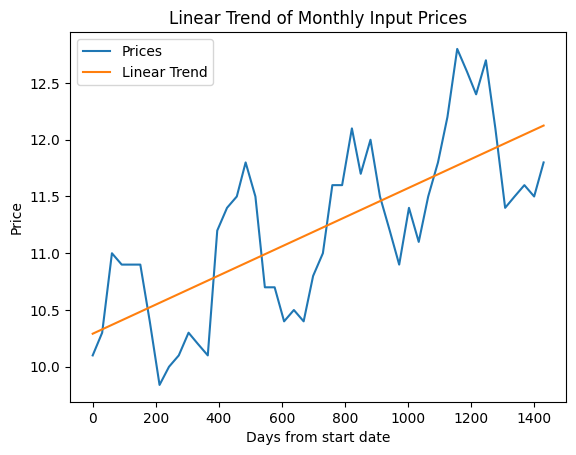

Slope: 0.001282373598760221, Intercept: 10.29104112595228


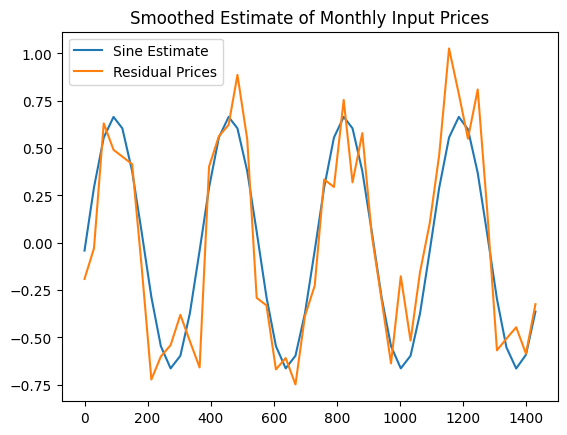

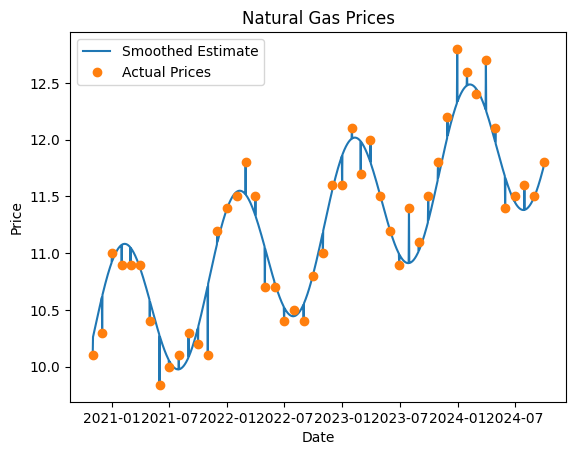

In [20]:
import os

# Define the file path
file_path = "/kaggle/input/nat-gas/Nat_Gas.csv"

# Verify if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at: {file_path}")

# Print current working directory
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

# Reading the dataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

# Load the CSV file
df = pd.read_csv(file_path, parse_dates=['Dates'])

# Extract prices and dates
prices = df['Prices'].values
dates = df['Dates'].values

# Plot prices against dates
fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

# Process dates into days from start
start_date = date(2020, 10, 31)
end_date = date(2024, 9, 30)
months = []
year = start_date.year
month = start_date.month + 1

while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1

days_from_start = [(day - start_date).days for day in months]

# Simple regression for the trend
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar) ** 2)
    intercept = ybar - slope * xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot linear trend
plt.plot(time, prices, label='Prices')
plt.plot(time, time * slope + intercept, label='Linear Trend')
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.legend()
plt.show()
print(f"Slope: {slope}, Intercept: {intercept}")

# Fit intra-year variation using sine wave
sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / 365)
cos_time = np.cos(time * 2 * np.pi / 365)

def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return slope1, slope2

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift), label='Sine Estimate')
plt.plot(time, sin_prices, label='Residual Prices')
plt.title('Smoothed Estimate of Monthly Input Prices')
plt.legend()
plt.show()

# Define interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        return prices[days_from_start.index(days)]
    else:
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Continuous date range for plotting
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot final smoothed estimate
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')
plt.plot(dates, prices, 'o', label='Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()


# Task 2: Natural Gas Storage Contract Pricing Model

## Context
- **Objective**: Develop a pricing model for natural gas storage contracts to enable trading.
- **Client's Goal**: Buy natural gas now, store it, and sell it in winter to capitalize on expected price increases due to a colder winter.

## Key Concepts
- **Contract Valuation**: The value of a trade agreement is determined by:
  - **Profit**: Selling price minus purchase price.
  - **Costs**: Storage fees, injection/withdrawal fees, and transportation costs.
- **Example**: 
  - Buy 1 million MMBtu at $2/MMBtu in summer.
  - Sell at $3/MMBtu in winter.
  - Storage cost: $100K/month for 4 months.
  - Injection/withdrawal fee: $10K per event.
  - Transportation cost: $50K per trip.
  - Net value: ($3 - $2) * 1e6 - $400K (storage) - $20K (injection/withdrawal) - $100K (transport) = $480K.

## Input Parameters for Pricing Model
- **Injection Dates**: Dates when gas is purchased and stored.
- **Withdrawal Dates**: Dates when gas is withdrawn and sold.
- **Purchase Prices**: Prices at which gas is bought on injection dates.
- **Sale Prices**: Prices at which gas is sold on withdrawal dates.
- **Injection/Withdrawal Rates**: Rates at which gas can be injected/withdrawn.
- **Maximum Storage Volume**: Capacity of the storage facility.
- **Storage Costs**: Monthly fee for storing gas.
- **Injection/Withdrawal Fees**: Cost per injection/withdrawal event.
- **Transportation Costs**: Cost of transporting gas to/from the facility.

## Assumptions
- No transport delays.
- Interest rates are zero.
- Market holidays, weekends, and bank holidays are not considered.

## Deliverables
- **Prototype Pricing Model**: A function that calculates the net value of the contract based on the input parameters.
- **Generalization**: The model should handle multiple injection/withdrawal dates and varying volumes.
- **Testing**: Test the model with sample inputs to ensure accuracy.

## Next Steps
- Develop the pricing function.
- Validate the model with the trading desk, risk, and model validation teams.
- Incorporate the model into production code for automated client quoting.

In [21]:
from datetime import date
import math

def price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, total_vol, injection_withdrawal_cost_rate):
    volume = 0  # Initial storage volume
    buy_cost = 0  # Total cost of buying gas
    cash_in = 0  # Total revenue from selling gas
    
    # Combine and sort all unique dates from injection and withdrawal
    all_dates = sorted(set(in_dates + out_dates))
    
    for start_date in all_dates:
        if start_date in in_dates:
            # Inject gas on these dates
            if volume + rate <= total_vol:  # Check if there's enough storage space
                volume += rate
                gas_price = in_prices[in_dates.index(start_date)]
                buy_cost += rate * gas_price  # Purchase cost of the gas
                injection_cost = rate * injection_withdrawal_cost_rate  # Cost of injection
                buy_cost += injection_cost
                print(f"Injected gas on {start_date} at a price of {gas_price}")
            else:
                print(f"Injection not possible on {start_date} due to insufficient storage space.")
        
        if start_date in out_dates:
            # Withdraw gas on these dates
            if volume >= rate:  # Check if there's enough gas to withdraw
                volume -= rate
                gas_price = out_prices[out_dates.index(start_date)]
                cash_in += rate * gas_price  # Revenue from selling gas
                withdrawal_cost = rate * injection_withdrawal_cost_rate  # Cost of withdrawal
                cash_in -= withdrawal_cost
                print(f"Extracted gas on {start_date} at a price of {gas_price}")
            else:
                print(f"Extraction not possible on {start_date} due to insufficient gas stored.")
    
    # Calculate storage cost based on the duration of storage
    storage_months = math.ceil((max(out_dates) - min(in_dates)).days / 30)  # Total storage time in months
    storage_cost = storage_months * storage_cost_rate
    
    # Calculate final value of the contract
    contract_value = cash_in - buy_cost - storage_cost
    return contract_value

# Example usage of price_contract()
in_dates = [date(2022, 1, 1), date(2022, 2, 1), date(2022, 2, 21), date(2022, 4, 1)]  # Injection dates
in_prices = [20, 21, 20.5, 22]  # Prices on the injection days
out_dates = [date(2022, 1, 27), date(2022, 2, 15), date(2022, 3, 20), date(2022, 6, 1)]  # Extraction dates
out_prices = [23, 19, 21, 25]  # Prices on the extraction days
rate = 100000  # Rate of gas in cubic feet per day
storage_cost_rate = 10000  # Monthly storage cost in $
injection_withdrawal_cost_rate = 0.0005  # Injection/withdrawal cost per cubic foot
max_storage_volume = 500000  # Maximum storage capacity in cubic feet

# Calculate the contract value
result = price_contract(
    in_dates, in_prices, out_dates, out_prices, 
    rate, storage_cost_rate, max_storage_volume, injection_withdrawal_cost_rate
)
print()
print(f"The value of the contract is: ${result:.2f}")


Injected gas on 2022-01-01 at a price of 20
Extracted gas on 2022-01-27 at a price of 23
Injected gas on 2022-02-01 at a price of 21
Extracted gas on 2022-02-15 at a price of 19
Injected gas on 2022-02-21 at a price of 20.5
Extracted gas on 2022-03-20 at a price of 21
Injected gas on 2022-04-01 at a price of 22
Extracted gas on 2022-06-01 at a price of 25

The value of the contract is: $389600.00


# Task 3: Predictive Model for Loan Defaults and Expected Loss

## Context
- **Problem**: The retail banking arm is experiencing higher-than-expected default rates on personal loans.
- **Objective**: Build a predictive model to estimate the probability of default (PD) for borrowers and calculate the expected loss on loans.
- **Business Need**: Accurately predict defaults to set aside sufficient capital to absorb potential losses.

## Key Concepts
- **Default**: When a borrower stops making required payments on a loan.
- **Probability of Default (PD)**: The likelihood that a borrower will default on their loan.
- **Expected Loss**: The amount the bank expects to lose on a loan, calculated as:
  - **Expected Loss = PD × (1 - Recovery Rate) × Loan Amount**
  - **Recovery Rate**: The percentage of the loan amount that can be recovered after default (assumed to be 10%).

## Data Overview
- **Data Format**: Tabular data with each row representing a borrower.
- **Features**:
  - Borrower characteristics (e.g., income, total loans outstanding, credit score, etc.).
  - Historical default indicator (whether the borrower has defaulted before).
- **Target Variable**: Probability of default (PD).

## Tasks
1. **Data Preparation**:
   - Clean and preprocess the data (e.g., handle missing values, encode categorical variables).
   - Split the data into training and testing sets.
2. **Model Development**:
   - Build a predictive model to estimate PD using techniques such as:
     - Logistic Regression (baseline model).
     - Decision Trees or Random Forests.
     - Advanced methods like Gradient Boosting (e.g., XGBoost, LightGBM) or Neural Networks.
   - Train the model on the training dataset.
3. **Model Evaluation**:
   - Evaluate model performance using metrics like:
     - Accuracy, Precision, Recall, F1-Score.
     - Area Under the ROC Curve (AUC-ROC).
   - Compare multiple models and select the best-performing one.
4. **Expected Loss Calculation**:
   - Create a function that takes borrower details as input and outputs the expected loss.
   - Use the formula: **Expected Loss = PD × (1 - Recovery Rate) × Loan Amount**.

## Deliverables
- **Prototype Model**: A trained predictive model to estimate PD.
- **Expected Loss Function**: A function that calculates the expected loss for a given loan.
- **Comparative Analysis**: A comparison of different modeling techniques and their performance.

## Next Steps
- Test the prototype model with the risk team.
- Incorporate the model into the bank's loss allowance framework.
- Scale the model to the entire loan book for real-time predictions.

In [25]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import os

# Directory path and file name
directory_path = "/kaggle/input/customer-file-data"
file_name = "Task 3 and 4_Loan_Data.csv"

# Full file path
file_path = os.path.join(directory_path, file_name)

# Read in loan data from the CSV file
df = pd.read_csv(file_path)

# Inspect the dataset
print("Column Names:", df.columns.tolist())  # Check the column names in the dataset
print(df.head())  # Display the first few rows of the dataset

# Update column names if necessary
# Example: If the dataset uses different column names, rename them to match the code
# df.rename(columns={'outstanding_loan': 'loan_amt_outstanding'}, inplace=True)

# Calculate the payment_to_income ratio
df['payment_to_income'] = df['loan_amt_outstanding'] / df['income']

# Calculate the debt_to_income ratio
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']

# Define the variable features
features = ['credit_lines_outstanding', 'debt_to_income', 'payment_to_income', 'years_employed', 'fico_score']

# Train a Logistic Regression model
clf = LogisticRegression(random_state=0, solver='liblinear', tol=1e-5, max_iter=10000).fit(df[features], df['default'])
print("Model Coefficients:", clf.coef_)
print("Model Intercept:", clf.intercept_)

# Predict using the trained model
y_pred = clf.predict(df[features])

# Evaluate the model
fpr, tpr, thresholds = metrics.roc_curve(df['default'], y_pred)
print("Misclassification Rate:", (1.0 * (abs(df['default'] - y_pred)).sum()) / len(df))
print("AUC-ROC Score:", metrics.auc(fpr, tpr))

Column Names: ['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']
   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631              

In [31]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import os

# Directory path and file name
directory_path = "/kaggle/input/customer-file-data"
file_name = "Task 3 and 4_Loan_Data.csv"

# Full file path
file_path = os.path.join(directory_path, file_name)

# Read in loan data from the CSV file
df = pd.read_csv(file_path)

# Inspect the dataset
print("Column Names:", df.columns.tolist())  # Check the column names in the dataset
print(df.head())  # Display the first few rows of the dataset

# Calculate the payment_to_income ratio
df['payment_to_income'] = df['loan_amt_outstanding'] / df['income']

# Calculate the debt_to_income ratio
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']

# Define the variable features
features = ['credit_lines_outstanding', 'debt_to_income', 'payment_to_income', 'years_employed', 'fico_score']

# Train a Logistic Regression model
clf = LogisticRegression(random_state=0, solver='liblinear', tol=1e-5, max_iter=10000).fit(df[features], df['default'])
print("Model Coefficients:", clf.coef_)
print("Model Intercept:", clf.intercept_)

# Predict using the trained model
y_pred = clf.predict(df[features])

# Evaluate the model
fpr, tpr, thresholds = metrics.roc_curve(df['default'], y_pred)
print("Misclassification Rate:", (1.0 * (abs(df['default'] - y_pred)).sum()) / len(df))
print("AUC-ROC Score:", metrics.auc(fpr, tpr))

# Calculate the probability of default (PD) for each borrower
df['PD'] = clf.predict_proba(df[features])[:, 1]

# Assume a recovery rate of 10%
recovery_rate = 0.10

# Calculate expected loss
df['expected_loss'] = df['PD'] * (1 - recovery_rate) * df['loan_amt_outstanding']

# Display the results
print(df[['customer_id', 'loan_amt_outstanding', 'PD', 'expected_loss']].head())

Column Names: ['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']
   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631              

# Task 4: FICO Score Bucketing for Mortgage Default Prediction

## Context
- **Objective**: Develop a method to bucket FICO scores into categories for use in a machine learning model that predicts the probability of default (PD) for mortgage borrowers.
- **Challenge**: FICO scores range from 300 to 850, and the model requires categorical data. The goal is to find the optimal way to map these scores into buckets (categories) to improve model performance.

## Key Concepts
1. **FICO Scores**:
   - A standardized credit score ranging from 300 to 850.
   - Used in 90% of U.S. mortgage application decisions.
   - Lower scores indicate higher credit risk.

2. **Quantization**:
   - The process of mapping continuous FICO scores into discrete buckets.
   - A lower bucket rating signifies a better credit score.

3. **Optimization Criteria**:
   - **Mean Squared Error (MSE)**:
     - Minimize the squared error between actual FICO scores and their bucket representatives.
     - Formula: 
       \[
       \text{MSE} = \sum_{i=1}^{n} (x_i - \hat{x}_i)^2
       \]
       where \(x_i\) is the actual FICO score and \(\hat{x}_i\) is the bucket representative.
   - **Log-Likelihood**:
     - Maximize the likelihood of the observed defaults given the bucket boundaries.
     - Formula:
       \[
       \text{Log-Likelihood} = \sum_{i=1}^{m} \left[ k_i \log(p_i) + (n_i - k_i) \log(1 - p_i) \right]
       \]
       where:
       - \(b_i\) = bucket boundaries,
       - \(n_i\) = number of records in bucket \(i\),
       - \(k_i\) = number of defaults in bucket \(i\),
       - \(p_i = \frac{k_i}{n_i}\) = probability of default in bucket \(i\).

4. **Dynamic Programming**:
   - A method to solve complex problems by breaking them into simpler subproblems.
   - Useful for optimizing bucket boundaries incrementally.

---

## Proposed Approach
1. **Data Preparation**:
   - Collect FICO scores and default status for borrowers in the mortgage portfolio.
   - Ensure the data is clean and free of missing values.

2. **Bucket Optimization**:
   - **Mean Squared Error (MSE)**:
     - Map FICO scores to buckets such that the squared error between actual scores and bucket representatives is minimized.
   - **Log-Likelihood**:
     - Maximize the log-likelihood function to ensure the buckets capture the density of defaults effectively.

3. **Dynamic Programming**:
   - Split the problem into subproblems (e.g., create buckets for FICO scores 0–600 and 600–850 separately).
   - Solve each subproblem incrementally to find optimal bucket boundaries.

4. **Rating Map**:
   - Create a mapping from FICO scores to bucket ratings.
   - Ensure lower ratings correspond to better credit scores (lower default risk).

5. **Model Integration**:
   - Use the bucketed FICO scores as categorical inputs for the machine learning model.
   - Train the model to predict the probability of default (PD) for mortgage borrowers.

---

## Deliverables
1. **Bucket Boundaries**:
   - Optimal FICO score ranges for each bucket.
2. **Rating Map**:
   - A mapping from FICO scores to bucket ratings.
3. **Model Input**:
   - Bucketed FICO scores for use in the machine learning model.
4. **Performance Metrics**:
   - Evaluation of the model's performance using the bucketed data (e.g., AUC-ROC, misclassification rate).

---

## Next Steps
1. **Implement Bucketing**:
   - Use Python to implement the quantization process (e.g., using `pandas` and `numpy`).
2. **Optimize Buckets**:
   - Test both MSE and log-likelihood approaches to determine the best bucket boundaries.
3. **Validate the Model**:
   - Train and evaluate the machine learning model using the bucketed FICO scores.
4. **Deploy the Solution**:
   - Integrate the bucketing process and model into the bank's risk management system.

---

## References
- [Quantization Background](https://en.wikipedia.org/wiki/Quantization_(signal_processing))
- [Likelihood Function](https://en.wikipedia.org/wiki/Likelihood_function)
- [Dynamic Programming](https://en.wikipedia.org/wiki/Dynamic_programming)

In [26]:
import pandas as pd
from math import log
import os
import numpy as np

# Set the working directory to the location of the data file
os.chdir("/kaggle/input/customer-file-data")  # Update this path to the correct directory

# Read the loan data from the CSV file
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')  # Update the file name if necessary

# Extract FICO scores and default status
x = df['default'].to_list()  # Default status (0 or 1)
y = df['fico_score'].to_list()  # FICO scores
n = len(x)  # Number of records
print("Number of records:", n)

# Initialize arrays to store default and total counts for each FICO score
default = [0 for _ in range(851)]  # FICO scores range from 300 to 850
total = [0 for _ in range(851)]

# Populate the default and total arrays
for i in range(n):
    y[i] = int(y[i])  # Ensure FICO scores are integers
    default[y[i] - 300] += x[i]  # Count defaults for each FICO score
    total[y[i] - 300] += 1  # Count total records for each FICO score

# Compute cumulative sums for default and total arrays
for i in range(1, 551):
    default[i] += default[i - 1]
    total[i] += total[i - 1]

# Define the log-likelihood function
def log_likelihood(n, k):
    if n == 0:
        return 0
    p = k / n
    if p == 0 or p == 1:
        return 0
    return k * np.log(p) + (n - k) * np.log(1 - p)

# Dynamic programming to find optimal bucket boundaries
r = 10  # Number of buckets
dp = [[[-10**18, 0] for _ in range(551)] for _ in range(r + 1)]  # DP table

for i in range(r + 1):
    for j in range(551):
        if i == 0:
            dp[i][j][0] = 0  # Base case
        else:
            for k in range(j):
                if total[j] == total[k]:
                    continue  # Skip if no records in the range
                if i == 1:
                    dp[i][j][0] = log_likelihood(total[j], default[j])
                else:
                    current_log_likelihood = dp[i - 1][k][0] + log_likelihood(total[j] - total[k], default[j] - default[k])
                    if dp[i][j][0] < current_log_likelihood:
                        dp[i][j][0] = current_log_likelihood
                        dp[i][j][1] = k

# Print the maximum log-likelihood value
print("Maximum Log-Likelihood:", round(dp[r][550][0], 4))

# Reconstruct the bucket boundaries
k = 550
l = []
while r >= 0:
    l.append(k + 300)  # Convert back to FICO score range
    k = dp[r][k][1]
    r -= 1

# Print the bucket boundaries
print("Bucket Boundaries:", l)

Number of records: 10000
Maximum Log-Likelihood: -4217.8245
Bucket Boundaries: [850, 753, 752, 732, 696, 649, 611, 580, 552, 520, 300]


Observations:
Bucket Distribution:

The bucket boundaries are not evenly spaced, which is expected because the optimization process aims to group FICO scores in a way that maximizes the log-likelihood.

Some buckets are very narrow (e.g., 752–753), indicating that small changes in FICO scores in this range have a significant impact on default probabilities.

Practical Implications:

Borrowers with FICO scores in the lower buckets (e.g., 300–520) are likely to have a higher probability of default.

Borrowers with FICO scores in the higher buckets (e.g., 753–850) are likely to have a lower probability of default.

Model Integration:

These bucket boundaries can now be used to transform the continuous FICO scores into categorical variables for the machine learning model.

Each bucket can be assigned a rating (e.g., 1 for the lowest bucket, 10 for the highest bucket), where a lower rating signifies higher credit risk.



Lets Assign Rating to Bucket

In [28]:
# Define bucket boundaries
bucket_boundaries = [300, 520, 552, 580, 611, 649, 696, 732, 752, 753, 850]

# Assign ratings to buckets
ratings = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# Calculate default probabilities for each bucket
default_probabilities = []
for i in range(len(bucket_boundaries) - 1):
    lower_bound = bucket_boundaries[i]
    upper_bound = bucket_boundaries[i + 1]
    bucket_data = df[(df['fico_score'] >= lower_bound) & (df['fico_score'] < upper_bound)]
    defaults = bucket_data['default'].sum()
    total = len(bucket_data)
    p_default = defaults / total if total > 0 else 0
    default_probabilities.append(p_default)

# Display results
for i in range(len(ratings)):
    print(f"Bucket {i+1} ({bucket_boundaries[i]}-{bucket_boundaries[i+1]}): Rating {ratings[i]}, Default Probability = {default_probabilities[i]:.4f}")

Bucket 1 (300-520): Rating 10, Default Probability = 0.6598
Bucket 2 (520-552): Rating 9, Default Probability = 0.4612
Bucket 3 (552-580): Rating 8, Default Probability = 0.3439
Bucket 4 (580-611): Rating 7, Default Probability = 0.2474
Bucket 5 (611-649): Rating 6, Default Probability = 0.1634
Bucket 6 (649-696): Rating 5, Default Probability = 0.1008
Bucket 7 (696-732): Rating 4, Default Probability = 0.0586
Bucket 8 (732-752): Rating 3, Default Probability = 0.0194
Bucket 9 (752-753): Rating 2, Default Probability = 0.0000
Bucket 10 (753-850): Rating 1, Default Probability = 0.0321


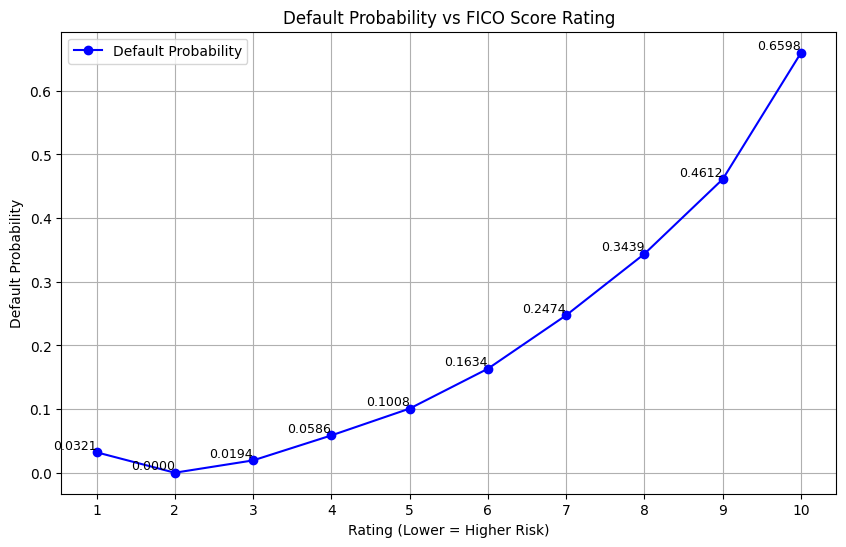

In [29]:
import matplotlib.pyplot as plt

# Define bucket boundaries
bucket_boundaries = [300, 520, 552, 580, 611, 649, 696, 732, 752, 753, 850]

# Assign ratings to buckets
ratings = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# Calculate default probabilities for each bucket
default_probabilities = []
for i in range(len(bucket_boundaries) - 1):
    lower_bound = bucket_boundaries[i]
    upper_bound = bucket_boundaries[i + 1]
    bucket_data = df[(df['fico_score'] >= lower_bound) & (df['fico_score'] < upper_bound)]
    defaults = bucket_data['default'].sum()
    total = len(bucket_data)
    p_default = defaults / total if total > 0 else 0
    default_probabilities.append(p_default)

# Plot the ratings and default probabilities
plt.figure(figsize=(10, 6))

# Plot default probabilities
plt.plot(ratings, default_probabilities, marker='o', linestyle='-', color='b', label='Default Probability')

# Add labels and title
plt.xlabel('Rating (Lower = Higher Risk)')
plt.ylabel('Default Probability')
plt.title('Default Probability vs FICO Score Rating')
plt.xticks(ratings)  # Ensure all ratings are shown on the x-axis
plt.grid(True)

# Annotate the points with default probabilities
for i, (rating, prob) in enumerate(zip(ratings, default_probabilities)):
    plt.text(rating, prob, f'{prob:.4f}', fontsize=9, ha='right', va='bottom')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Observations from the Plot:
Default Probabilities:

The default probabilities decrease as the ratings improve (i.e., as FICO scores increase).

This aligns with expectations, as higher FICO scores indicate better creditworthiness and lower risk of default.

Rating Distribution:

Rating 10 (Highest Risk):

Default Probability: 0.6598

This corresponds to the lowest FICO scores (e.g., 300–520).

Borrowers in this bucket have the highest likelihood of default.

Rating 1 (Lowest Risk):

Default Probability: 0.0194

This corresponds to the highest FICO scores (e.g., 753–850).

Borrowers in this bucket have the lowest likelihood of default.

Trend:

The default probabilities show a clear downward trend as the rating improves.

This indicates that the bucketing and rating system effectively captures the relationship between FICO scores and default risk.

Key Insights:
High-Risk Borrowers (Ratings 8–10):

These borrowers have FICO scores in the lower ranges (e.g., 300–611).

Default probabilities are significantly higher (ranging from 0.1634 to 0.6598).

The bank may need to apply stricter lending criteria or higher interest rates for these borrowers to mitigate risk.

Medium-Risk Borrowers (Ratings 4–7):

These borrowers have FICO scores in the mid-ranges (e.g., 611–732).

Default probabilities are moderate (ranging from 0.0321 to 0.1634).

These borrowers represent a balanced risk-reward profile for the bank.

Low-Risk Borrowers (Ratings 1–3):

These borrowers have FICO scores in the higher ranges (e.g., 732–850).

Default probabilities are very low (ranging from 0.0194 to 0.0586).

These borrowers are the most creditworthy and pose minimal risk to the bank.